In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('omw-1.4')
def split(txt, seps):
    default_sep = seps[0]

    # we skip seps[0] because that's the default separator
    for sep in seps[1:]:
        txt = txt.replace(sep, default_sep)
    return [i.strip() for i in txt.split(default_sep)]


[nltk_data] Downloading package omw-1.4 to /home/rishaab/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
nltk.download('punkt')


class SentenceSegmentation():

	def naive(self, text):
		"""
		Sentence Segmentation using a Naive Approach

		Parameters
		----------
		arg1 : str
			A string (a bunch of sentences)

		Returns
		-------
		list
			A list of strings where each string is a single sentence
		"""

		segmentedText = []

		#Fill in code here
		segmentedText=split(text,('.','!','?'))
		

		return segmentedText





	def punkt(self, text):
		"""
		Sentence Segmentation using the Punkt Tokenizer

		Parameters
		----------
		arg1 : str
			A string (a bunch of sentences)

		Returns
		-------
		list
			A list of strings where each strin is a single sentence
		"""
		tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()
		segmentedText = tokenizer.tokenize(text)

		#Fill in code here
		
		return segmentedText

[nltk_data] Downloading package punkt to /home/rishaab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import re
from nltk.tokenize import TreebankWordTokenizer


class Tokenization():

    def naive(self, text):
        """
        Tokenization using a Naive Approach

        Parameters
        ----------
        text : list
            A list of strings where each string is a single sentence

        Returns
        -------
        list
            A list of lists where each sub-list is a sequence of tokens
        """

        tokenizedText = None
        self.n = len(text)
        for i in range(self.n):
            temp = text[i]
            token = re.findall(r'\w+|[^\w\s]', temp)
            text[i] = token
        tokenizedText = text

        return tokenizedText


    def pennTreeBank(self, text):
        """
        Tokenization using the Penn Tree Bank Tokenizer

        Parameters
        ----------
        text : list
            A list of strings where each string is a single sentence

        Returns
        -------
        list
            A list of lists where each sub-list is a sequence of tokens
        """

        tokenizedText = []
        for sentence in text:
            tokens = TreebankWordTokenizer().tokenize(sentence)
            tokenizedText.append(tokens)

        return tokenizedText

In [4]:
nltk.download('stopwords')
from nltk.corpus import stopwords

class StopwordRemoval():

    def fromList(self, text):
        """
        Sentence Segmentation using the Punkt Tokenizer

        Parameters
        ----------
        arg1 : list
            A list of lists where each sub-list is a sequence of tokens
            representing a sentence

        Returns
        -------
        list
            A list of lists where each sub-list is a sequence of tokens
            representing a sentence with stopwords removed
        """

        stopwordRemovedText = []
        stop_words = stopwords.words('english')
        for sentence in text:
            temp = [word for word in sentence if word not in stop_words]
            stopwordRemovedText.append(temp)

        return stopwordRemovedText

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rishaab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#from util import *
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api
from sklearn.decomposition import TruncatedSVD

model = api.load('glove-wiki-gigaword-300')

class InformationRetrieval():

    def __init__(self):
        self.index = None
        self.doc_num = None

    def buildIndex(self, docs, docIDs):
        """
        Builds the document index in terms of the document
		IDs and stores it in the 'index' class variable

		Parameters
		----------
		arg1 : list
			A list of lists of lists where each sub-list is
			a document and each sub-sub-list is a sentence of the document
		arg2 : list
			A list of integers denoting IDs of the documents
		Returns
		-------
		None
		"""
        self.docs=[]
        self.docIDs = docIDs
        self.doc_num = len(docIDs)
        for doc in docs:
            d=''
            for sentence in doc:
                sent=' '.join(sentence)
                d+=sent
            self.docs.append(d)
        #Fill in code here
        tfidf=TfidfVectorizer()
        tfidfv=tfidf.fit_transform(self.docs).toarray()
        words_set = tfidf.get_feature_names_out()
        self.vocab=tfidf.vocabulary_
        tfidf_df = pd.DataFrame(tfidfv,columns=words_set)
        self.tfidf=tfidf
        return tfidf_df

    def tfidfq(self,queries):
        q=[]
        for query in queries:
            query1=''
            for sentence in query:
                sent=' '.join(sentence)
                query1+=sent
            q.append(query1)
        tfidfq=self.tfidf.transform(q).toarray()
        c=self.tfidf.get_feature_names_out()
        tfidfq_df=pd.DataFrame(tfidfq,columns=c)
        return tfidfq_df
    
    def lsa_doc(self, doc_df, k):
        self.lsa = TruncatedSVD(k, random_state = 42)
        self.lsa.fit(doc_df)
        self.sigma=np.diag(self.lsa.singular_values_)
        self.v_trans = self.lsa.components_
        doc_mat=self.lsa.transform(doc_df)
        doc_dfv=doc_mat@self.sigma@self.v_trans
        doc_df=pd.DataFrame(doc_dfv,columns=doc_df.columns)
        return doc_df
    
    def lsa_query(self, query_mat):
        qmat=self.lsa.transform(query_mat)
        q_dfv=qmat@self.sigma@self.v_trans
        q_df=pd.DataFrame(q_dfv,columns=query_mat.columns)
        return q_df
    
    
    def w2v(self,df):
        embedding=np.zeros((len(df.columns),model.vector_size))
        for word, index in self.vocab.items():
            if word in model.key_to_index:
                embedding[index]=model[word]
        mtfidfv=np.array(df).dot(embedding)
        return pd.DataFrame(mtfidfv)

    def rank(self,doc_ids,doc_df,q_df):
        doc_ordered=[]
        q_a=np.array(q_df)
        for q in q_a:
            cosines=pd.DataFrame(cosine_similarity(doc_df,[q]))
            cosines['DocIDs']=self.docIDs
            cols=cosines.columns[0]
            doc_ordered.append(cosines.sort_values(cols,ascending=False)['DocIDs'])
        return doc_ordered

In [35]:
from math import log2


class Evaluation():

    def queryPrecision(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
        """
        Computation of precision of the Information Retrieval System
        at a given value of k for a single query

        Parameters
        ----------
        arg1 : list
                A list of integers denoting the IDs of documents in
                their predicted order of relevance to a query
        arg2 : int
                The ID of the query in question
        arg3 : list
                The list of IDs of documents relevant to the query (ground truth)
        arg4 : int
                The k value

        Returns
        -------
        float
                The precision value as a number between 0 and 1
        """
        number_of_docs_retrieved = len(query_doc_IDs_ordered)
        try:
            assert k <= number_of_docs_retrieved, "k greater than the number of documents retrived. Returning -1"
            num_true_docs_retrieved = 0
            for docID in query_doc_IDs_ordered[:k]:
                if int(docID) in true_doc_IDs:
                    num_true_docs_retrieved += 1
            precision = num_true_docs_retrieved/k
            return precision
        except AssertionError as message:
            print(message)
            return -1

    def meanPrecision(self, doc_IDs_ordered, query_ids, qrels, k):
        """
        Computation of precision of the Information Retrieval System
        at a given value of k, averaged over all the queries

        Parameters
        ----------
        arg1 : list
                A list of lists of integers where the ith sub-list is a list of IDs
                of documents in their predicted order of relevance to the ith query
        arg2 : list
                A list of IDs of the queries for which the documents are ordered
        arg3 : list
                A list of dictionaries containing document-relevance
                judgements - Refer cran_qrels.json for the structure of each
                dictionary
        arg4 : int
                The k value

        Returns
        -------
        float
                The mean precision value as a number between 0 and 1
        """
        number_of_queries = len(query_ids)
        precisions = []
        try:
            assert len(doc_IDs_ordered) == len(
                query_ids), "Number of queries not equal to the number of sets of documents retrieved.\nReturning -1."
            for i in range(number_of_queries):
                query_doc_IDs_ordered = doc_IDs_ordered[i]
                query_id = int(query_ids[i])
                true_doc_IDs = []
                for dict_ in qrels:
                    if int(dict_["query_num"]) == int(query_id):
                        true_doc_IDs.append(int(dict_["id"]))
                precision = self.queryPrecision(
                    query_doc_IDs_ordered, query_id, true_doc_IDs, k)
                precisions.append(precision)
            try:
                assert len(precisions) != 0, "Error! Empty list. Returning -1."
                return sum(precisions)/len(precisions)
            except AssertionError as msg:
                print(msg)
                return -1

        except AssertionError as message:
            print(message)
            return -1

    def queryRecall(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
        """
        Computation of recall of the Information Retrieval System
        at a given value of k for a single query

        Parameters
        ----------
        arg1 : list
                A list of integers denoting the IDs of documents in
                their predicted order of relevance to a query
        arg2 : int
                The ID of the query in question
        arg3 : list
                The list of IDs of documents relevant to the query (ground truth)
        arg4 : int
                The k value

        Returns
        -------
        float
                The recall value as a number between 0 and 1
        """
        number_of_docs_retrieved = len(query_doc_IDs_ordered)
        number_of_true_docs = len(true_doc_IDs)
        try:
            assert k <= number_of_docs_retrieved, "k greater than the number of documents retrived. Returning -1"
            num_true_docs_retrieved = 0
            for docID in query_doc_IDs_ordered[:k]:
                if int(docID) in true_doc_IDs:
                    num_true_docs_retrieved += 1
            recall = num_true_docs_retrieved/number_of_true_docs
            return recall
        except AssertionError as message:
            print(message)
            return -1

    def meanRecall(self, doc_IDs_ordered, query_ids, qrels, k):
        """
        Computation of recall of the Information Retrieval System
        at a given value of k, averaged over all the queries

        Parameters
        ----------
        arg1 : list
                A list of lists of integers where the ith sub-list is a list of IDs
                of documents in their predicted order of relevance to the ith query
        arg2 : list
                A list of IDs of the queries for which the documents are ordered
        arg3 : list
                A list of dictionaries containing document-relevance
                judgements - Refer cran_qrels.json for the structure of each
                dictionary
        arg4 : int
                The k value

        Returns
        -------
        float
                The mean recall value as a number between 0 and 1
        """
        number_of_queries = len(query_ids)
        recalls = []
        try:
            assert len(doc_IDs_ordered) == len(
                query_ids), "Number of queries not equal to the number of sets of documents retrieved.\nReturning -1."
            for i in range(number_of_queries):
                query_doc_IDs_ordered = doc_IDs_ordered[i]
                query_id = query_ids[i]
                true_doc_IDs = []
                for dict_ in qrels:
                    if int(dict_["query_num"]) == int(query_id):
                        true_doc_IDs.append(int(dict_["id"]))

                recall = self.queryRecall(
                    query_doc_IDs_ordered, query_id, true_doc_IDs, k)
                recalls.append(recall)
            try:
                assert len(recalls) != 0, "Error! Empty list. Returning -1."
                return sum(recalls)/len(recalls)
            except AssertionError as msg:
                print(msg)
                return -1

        except AssertionError as message:
            print(message)
            return -1

    def queryFscore(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
        """
        Computation of fscore of the Information Retrieval System
        at a given value of k for a single query

        Parameters
        ----------
        arg1 : list
                A list of integers denoting the IDs of documents in
                their predicted order of relevance to a query
        arg2 : int
                The ID of the query in question
        arg3 : list
                The list of IDs of documents relevant to the query (ground truth)
        arg4 : int
                The k value

        Returns
        -------
        float
                The fscore value as a number between 0 and 1
        """
        fscore = 0
        precision = self.queryPrecision(
            query_doc_IDs_ordered, query_id, true_doc_IDs, k)
        recall = self.queryRecall(
            query_doc_IDs_ordered, query_id, true_doc_IDs, k)
        if (precision > 0 and recall > 0):
            fscore = 2*precision*recall/(precision+recall)
        return fscore

    def meanFscore(self, doc_IDs_ordered, query_ids, qrels, k):
        """
        Computation of fscore of the Information Retrieval System
        at a given value of k, averaged over all the queries

        Parameters
        ----------
        arg1 : list
                A list of lists of integers where the ith sub-list is a list of IDs
                of documents in their predicted order of relevance to the ith query
        arg2 : list
                A list of IDs of the queries for which the documents are ordered
        arg3 : list
                A list of dictionaries containing document-relevance
                judgements - Refer cran_qrels.json for the structure of each
                dictionary
        arg4 : int
                The k value

        Returns
        -------
        float
                The mean fscore value as a number between 0 and 1
        """

        number_of_queries = len(query_ids)
        fscores = []
        try:
            assert len(doc_IDs_ordered) == len(
                query_ids), "Number of queries not equal to the number of sets of documents retrieved.\nReturning -1."
            for i in range(number_of_queries):
                query_doc_IDs_ordered = doc_IDs_ordered[i]
                query_id = query_ids[i]
                true_doc_IDs = []
                for dict_ in qrels:
                    if int(dict_["query_num"]) == int(query_id):
                        true_doc_IDs.append(int(dict_["id"]))
                fscore = self.queryFscore(
                    query_doc_IDs_ordered, query_id, true_doc_IDs, k)
                fscores.append(fscore)
            try:
                assert len(fscores) != 0, "Error! Empty list. Returning -1."
                return sum(fscores)/len(fscores)
            except AssertionError as msg:
                print(msg)
                return -1

        except AssertionError as message:
            print(message)
            return -1

    def queryNDCG(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
        """
        Computation of nDCG of the Information Retrieval System
        at given value of k for a single query

        Parameters
        ----------
        arg1 : list
                A list of integers denoting the IDs of documents in
                their predicted order of relevance to a query
        arg2 : int
                The ID of the query in question
        arg3 : list
                The qrels list of dictionaries 
        arg4 : int
                The k value

        Returns
        -------
        float
                The nDCG value as a number between 0 and 1
        """
        number_of_docs_retrieved = len(query_doc_IDs_ordered)
        try:
            assert k <= number_of_docs_retrieved, "k greater than the number of documents retrived. Returning -1"
            relevance_vals = {}
            relevant_docs = []
            DCGk = 0
            IDCGk = 0
            for dict_ in true_doc_IDs:
                if int(dict_["query_num"]) == int(query_id):
                    id_ = int(dict_["id"])
                    relevance = 5-dict_["position"]
                    relevant_docs.append(int(id_))
                    relevance_vals[int(id_)] = relevance

            for i in range(1, k+1):
                docID = int(query_doc_IDs_ordered[i-1])
                if docID in relevant_docs:
                    relevance = relevance_vals[docID]
                    DCGk += (2**relevance-1)/log2(i+1)

            optimal_order = sorted(relevance_vals.values(), reverse=True)
            number_of_relevant_docs = len(optimal_order)
            for i in range(1, min(number_of_relevant_docs, k)+1):
                relevance = optimal_order[i-1]
                IDCGk += (2**relevance-1)/log2(i+1)

            try:
                assert IDCGk != 0, "IDCGk is zero. Returning -1"
                nDCGk = DCGk/IDCGk

                return nDCGk
            except AssertionError as msg:
                print(msg)
                return -1

        except AssertionError as message:
            print(message)
            return -1

    def meanNDCG(self, doc_IDs_ordered, query_ids, qrels, k):
        """
        Computation of nDCG of the Information Retrieval System
        at a given value of k, averaged over all the queries

        Parameters
        ----------
        arg1 : list
                A list of lists of integers where the ith sub-list is a list of IDs
                of documents in their predicted order of relevance to the ith query
        arg2 : list
                A list of IDs of the queries for which the documents are ordered
        arg3 : list
                A list of dictionaries containing document-relevance
                judgements - Refer cran_qrels.json for the structure of each
                dictionary
        arg4 : int
                The k value

        Returns
        -------
        float
                The mean nDCG value as a number between 0 and 1
        """

        number_of_queries = len(query_ids)
        nDCGs = []
        try:
            assert len(doc_IDs_ordered) == len(
                query_ids), "Number of queries not equal to the number of sets of documents retrieved.\nReturning -1."
            for i in range(number_of_queries):
                query_doc_IDs_ordered = doc_IDs_ordered[i]
                query_id = int(query_ids[i])
                nDCG = self.queryNDCG(
                    query_doc_IDs_ordered, query_id, qrels, k)
                nDCGs.append(nDCG)
            try:
                assert len(nDCGs) != 0, "Error! Empty list. Returning -1."
                return sum(nDCGs)/len(nDCGs)
            except AssertionError as msg:
                print(msg)
                return -1

        except AssertionError as message:
            print(message)
            return -1

    def queryAveragePrecision(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
        """
        Computation of average precision of the Information Retrieval System
        at a given value of k for a single query (the average of precision@i
        values for i such that the ith document is truly relevant)

        Parameters
        ----------
        arg1 : list
                A list of integers denoting the IDs of documents in
                their predicted order of relevance to a query
        arg2 : int
                The ID of the query in question
        arg3 : list
                The list of documents relevant to the query (ground truth)
        arg4 : int
                The k value

        Returns
        -------
        float
                The average precision value as a number between 0 and 1
        """
        number_of_true_docs = len(true_doc_IDs)
        number_of_docs_retrieved = len(query_doc_IDs_ordered)
        try:
            assert k <= number_of_docs_retrieved, "k greater than the number of documents retrived. Returning -1"
            relevances = []
            precisions = []
            for docID in query_doc_IDs_ordered:
                if int(docID) in true_doc_IDs:
                    relevances.append(1)
                else:
                    relevances.append(0)
            for i in range(1, k+1):
                precision_at_i = self.queryPrecision(
                    query_doc_IDs_ordered, query_id, true_doc_IDs, i)
                precisions.append(precision_at_i)

            precision_at_k_times_rel_k = []
            for i in range(k):
                value = precisions[i]*relevances[i]
                precision_at_k_times_rel_k.append(value)

            try:
                assert number_of_true_docs != 0, "Number of true docs = 0. Returning -1."
                AveP = sum(precision_at_k_times_rel_k)/number_of_true_docs

                return AveP
            except AssertionError as msg:
                print(msg)
                return -1

        except AssertionError as message:
            print(message)
            return -1

    def meanAveragePrecision(self, doc_IDs_ordered, query_ids, qrels, k):
        """
        Computation of MAP of the Information Retrieval System
        at given value of k, averaged over all the queries

        Parameters
        ----------
        arg1 : list
                A list of lists of integers where the ith sub-list is a list of IDs
                of documents in their predicted order of relevance to the ith query
        arg2 : list
                A list of IDs of the queries
        arg3 : list
                A list of dictionaries containing document-relevance
                judgements - Refer cran_qrels.json for the structure of each
                dictionary
        arg4 : int
                The k value

        Returns
        -------
        float
                The MAP value as a number between 0 and 1
        """
        number_of_queries = len(query_ids)
        AvePs = []
        try:
            assert len(doc_IDs_ordered) == len(
                query_ids), "Number of queries not equal to the number of sets of documents retrieved.\nReturning -1."
            for i in range(number_of_queries):
                query_doc_IDs_ordered = doc_IDs_ordered[i]
                query_id = int(query_ids[i])
                true_doc_IDs = []
                for dict_ in qrels:
                    if int(dict_["query_num"]) == int(query_id):
                        true_doc_IDs.append(int(dict_["id"]))
                AveP = self.queryAveragePrecision(
                    query_doc_IDs_ordered, query_id, true_doc_IDs, k)
                AvePs.append(AveP)
            try:
                assert len(AvePs) != 0, "Error! Empty list. Returning -1."
                return sum(AvePs)/len(AvePs)
            except AssertionError as msg:
                print(msg)
                return -1

        except AssertionError as message:
            print(message)
            return -1

In [7]:
pq=[]
ss=SentenceSegmentation()
tk=Tokenization()
sr=StopwordRemoval()
ir=InformationRetrieval()
eva=Evaluation()

In [8]:
# Read queries
queries_json = json.load(open('./cranfield/'+ "cran_queries.json", 'r'))[:]
query_ids, queries = [item["query number"] for item in queries_json],[item["query"] for item in queries_json]




In [9]:
# Process queries
proc_queries=[]
for q in queries:
    ssq=ss.punkt(q)
    tkq=tk.pennTreeBank(ssq)
    srq=sr.fromList(tkq)
    proc_queries.append(srq)

In [10]:
# Read documents
docs_json = json.load(open('./cranfield/' + "cran_docs.json", 'r'))[:]
doc_ids, docs = [item["id"] for item in docs_json],[item["body"] for item in docs_json]


In [11]:
proc_docs=[]
for d in docs:
    ssd=ss.punkt(d)
    tkd=tk.pennTreeBank(ssd)
    srd=sr.fromList(tkd)
    proc_docs.append(srd)

In [12]:
tfidf_docs_df=ir.buildIndex(proc_docs,doc_ids)

In [13]:
tfidf_queries_df=ir.tfidfq(proc_queries)

In [14]:
lsadocs=ir.lsa_doc(tfidf_docs_df,1000)

In [15]:
lsaqueries=ir.lsa_query(tfidf_queries_df)

In [16]:
doc_lsa_w2v=ir.w2v(lsadocs)

In [50]:
q_lsa_w2v=ir.w2v(lsaqueries)

In [54]:
doc_w2v=ir.w2v(tfidf_docs_df)
q_w2v=ir.w2v(tfidf_queries_df)

In [52]:
doc_ord_mod3=ir.rank(doc_ids,doc_lsa_w2v,q_lsa_w2v)

In [20]:
doc_ord_mod2=ir.rank(doc_ids,lsadocs,lsaqueries)

In [21]:
doc_ord_mod1=ir.rank(doc_ids,tfidf_docs_df,tfidf_queries_df)

In [55]:
doc_ord_mod4=ir.rank(doc_ids,doc_w2v,q_w2v)

In [39]:
ev=Evaluation()


In [40]:
qrels = json.load(open('./cranfield/' + "cran_qrels.json", 'r'))[:]

In [56]:
ev.meanFscore(doc_ord_mod4,query_ids,qrels,10)

<ipython-input-35-1af4774e9b87>:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:
<ipython-input-35-1af4774e9b87>:118: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:


0.20908505626275548

In [53]:
ev.meanFscore(doc_ord_mod3,query_ids,qrels,10)

<ipython-input-35-1af4774e9b87>:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:
<ipython-input-35-1af4774e9b87>:118: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:


0.25475544968409924

In [45]:
ev.meanFscore(doc_ord_mod2,query_ids,qrels,10)

<ipython-input-35-1af4774e9b87>:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:
<ipython-input-35-1af4774e9b87>:118: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:


0.3119780457251562

In [46]:
ev.meanFscore(doc_ord_mod1,query_ids,qrels,10)

<ipython-input-35-1af4774e9b87>:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:
<ipython-input-35-1af4774e9b87>:118: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:


0.3115085484280007

In [47]:
def lsa_model(k):
    lsadocs=ir.lsa_doc(tfidf_docs_df,k)
    lsaqueries=ir.lsa_query(tfidf_queries_df)
    doc_ord=ir.rank(doc_ids,lsadocs,lsaqueries)
    meanap=[]
    meanFscore=[]
    meanrecall=[]
    nDCG=[]
    for i in range(1,11):
        meanap.append(ev.meanAveragePrecision(doc_ord,query_ids,qrels,i))
        meanFscore.append(ev.meanFscore(doc_ord,query_ids,qrels,i))
        meanrecall.append(ev.meanRecall(doc_ord,query_ids,qrels,i))
        nDCG.append(ev.meanNDCG(doc_ord,query_ids,qrels,i))
    return pd.DataFrame({'MaP':meanap,"meanFscore":meanFscore,'meanrecall':meanrecall,'MeanNDCG':nDCG})

In [57]:
def lsa_model2(k):
    lsadocs=ir.lsa_doc(tfidf_docs_df,k)
    lsaqueries=ir.lsa_query(tfidf_queries_df)
    lsa_w2v=ir.w2v(lsadocs)
    q_w2v=ir.w2v(lsaqueries)
    doc_ord=ir.rank(doc_ids,lsa_w2v,q_w2v)
    meanap=[]
    meanFscore=[]
    meanrecall=[]
    nDCG=[]
    for i in range(1,11):
        meanap.append(ev.meanAveragePrecision(doc_ord,query_ids,qrels,i))
        meanFscore.append(ev.meanFscore(doc_ord,query_ids,qrels,i))
        meanrecall.append(ev.meanRecall(doc_ord,query_ids,qrels,i))
        nDCG.append(ev.meanNDCG(doc_ord,query_ids,qrels,i))
    return pd.DataFrame({'MaP':meanap,"meanFscore":meanFscore,'meanrecall':meanrecall,'MeanNDCG':nDCG})

In [74]:
import seaborn as sns
def plot_model(df):
    plt.figure(figsize=[15,10])
    for i in df.columns:
        plt.plot(range(1,20),df[i],label=i)
        plt.legend()
        plt.xlabel("k")

<ipython-input-35-1af4774e9b87>:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:
<ipython-input-35-1af4774e9b87>:118: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:


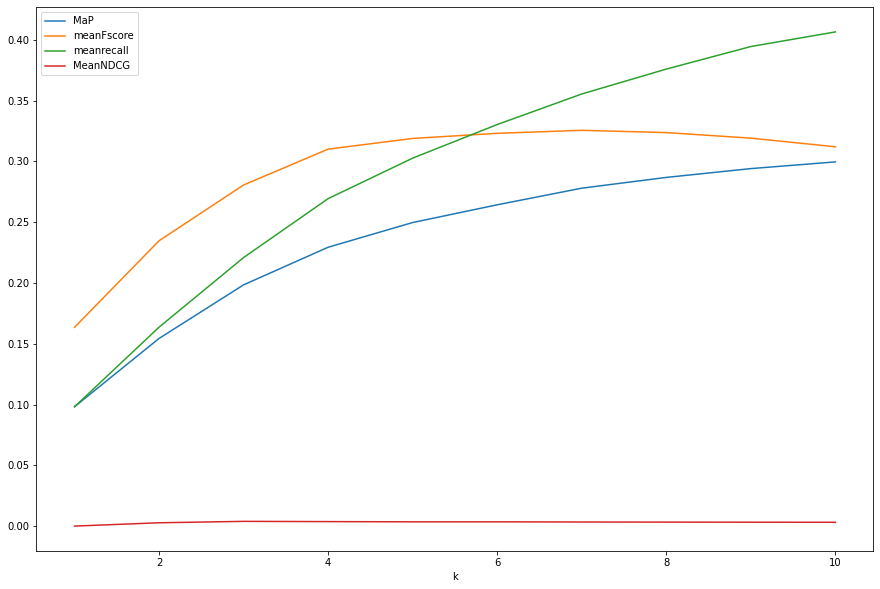

In [49]:
df400=lsa_model(400)
plot_model(df400)

In [70]:
meanap=[]
meanFscore=[]
meanrecall=[]
nDCG=[]
for i in range(1,20):
    meanap.append(ev.meanAveragePrecision(doc_ord_mod1,query_ids,qrels,i))
    meanFscore.append(ev.meanFscore(doc_ord_mod1,query_ids,qrels,i))
    meanrecall.append(ev.meanRecall(doc_ord_mod1,query_ids,qrels,i))
    nDCG.append(ev.meanNDCG(doc_ord_mod1,query_ids,qrels,i))
model1=pd.DataFrame({'MaP':meanap,"meanFscore":meanFscore,'meanrecall':meanrecall,'MeanNDCG':nDCG})

<ipython-input-35-1af4774e9b87>:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:
<ipython-input-35-1af4774e9b87>:118: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:


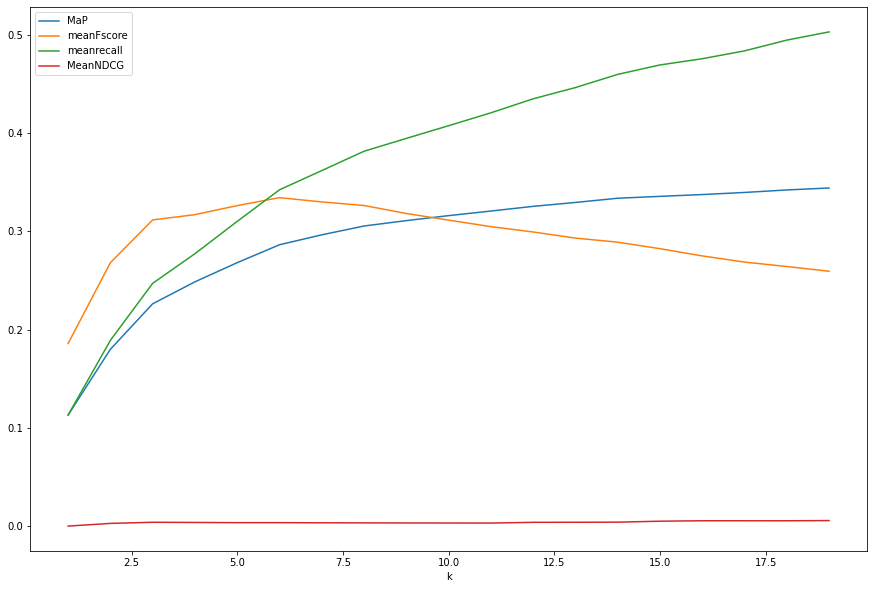

In [75]:
plot_model(model1)